### Edgar Moises Hernandez-Gonzalez
#### 26/06/20-19/11/20
#### Clasificacion de calculo mental en EEG con CNN + LSTM
##### Caracteristicas = Escalogramas CWT (3D)
##### Resize proporcional de (45 x n_canales / 2) x 1440 / 2 [720x672]
##### Validacion cruzada de 5

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pywt
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (f1_score, confusion_matrix,
                             roc_auc_score, roc_curve)
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense, Dropout)
from keras.optimizers import Adam
#from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
# todos los canales
x = pd.read_csv("/content/drive/My Drive/MentalCalculation/Datos/MeCa_car_05_3.csv", header=None)

# etiquetas
y = pd.read_csv("/content/drive/My Drive/MentalCalculation/Datos/EtiquetasMeCa05ECGT-03.csv", header=None).values

In [ ]:
print(x.shape)
print(y.shape)

(264, 43008)
(264, 1)


In [ ]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 264


In [ ]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 2


In [ ]:
# unir 32 canales y resize de tamaño proporcional
def unir_escalogramas_vertical(data):
  dim = (672, 720) #ancho, alto
  fs = 512
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  datos = np.zeros((data.shape[0],720,672))
  temporal = np.zeros((1440,1344))
  for i in range(data.shape[0]): #n muestras
    for j in range(32): #n canales
      sig = data.iloc[i, j*1344:(j+1)*1344]
      #sig = sig[160:1184]
      #escalograma CWT
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3', sampling_period = (1 / 512))
      temporal[j*45:(j+1)*45, :] = np.log(abs(coef))
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [ ]:
# llamar a unir_escalogramas_vertical
inicio = time.time()

x = unir_escalogramas_vertical(x)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
Tiempo: 322.0004789829254


In [ ]:
print(x.shape)

(264, 720, 672)


In [ ]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

4.000204108536641
-4.921545996115882
0.8215798876326968


In [ ]:
# convertir a float
x = x.astype('float32')

# escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [ ]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.80004084
-0.9843092
0.16431637


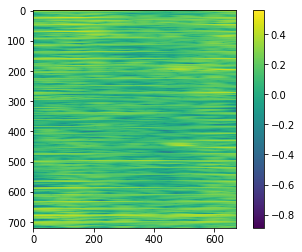

In [ ]:
plt.figure()
plt.imshow(x[0])
plt.colorbar()
plt.show()

In [ ]:
# convertir de 3D a 5D
x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2], 1))

print(x.shape)

(264, 1, 720, 672, 1)


In [ ]:
#mc = ModelCheckpoint('/content/drive/My Drive/MentalCalculation/Modelos/CNNRNN_CWT_15_3_CV.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=0)

In [ ]:
skf = StratifiedKFold(n_splits = 5)

In [ ]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(8, (15,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(8, (15,3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(8, activation='tanh', dropout=0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1
loss:  0.5948922038078308
accuracy:  0.7358490824699402
f1: 0.6968954248366013
confusion matrix:
 [[10  9]
 [ 5 29]]
AUC 0.8297213622291022


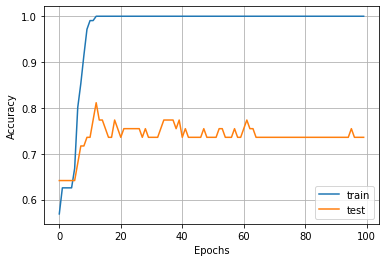

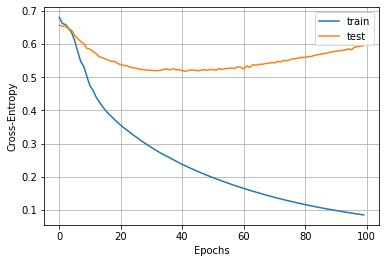


Iteration: 2
loss:  0.3833436667919159
accuracy:  0.8867924809455872
f1: 0.8795454545454545
confusion matrix:
 [[17  3]
 [ 3 30]]
AUC 0.9333333333333333


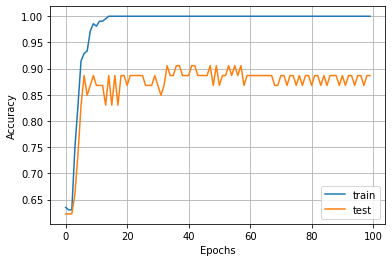

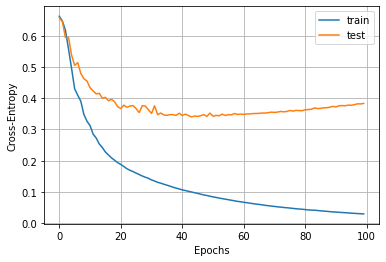


Iteration: 3
loss:  0.4808255732059479
accuracy:  0.849056601524353
f1: 0.8209459459459458
confusion matrix:
 [[12  8]
 [ 0 33]]
AUC 0.9166666666666667


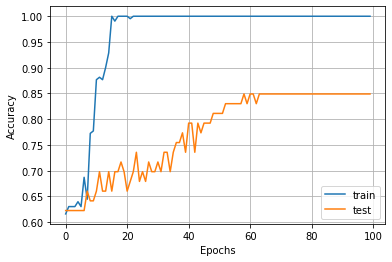

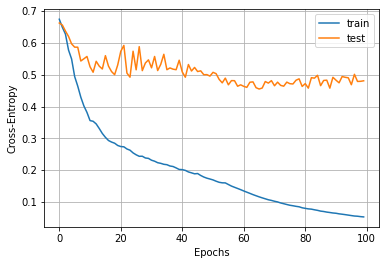


Iteration: 4
loss:  0.4575273394584656
accuracy:  0.8301886916160583
f1: 0.8131609870740305
confusion matrix:
 [[14  6]
 [ 3 30]]
AUC 0.9090909090909092


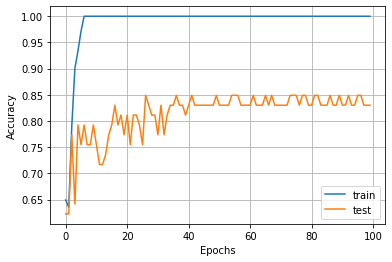

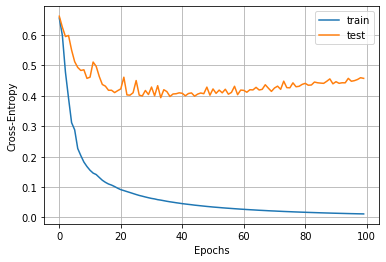


Iteration: 5
loss:  0.5706756114959717
accuracy:  0.7307692170143127
f1: 0.6578947368421053
confusion matrix:
 [[ 7 12]
 [ 2 31]]
AUC 0.8165869218500799


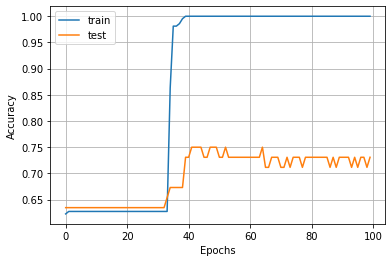

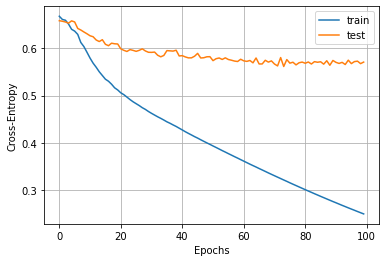


Resultados:
loss: [0.5948922038078308, 0.3833436667919159, 0.4808255732059479, 0.4575273394584656, 0.5706756114959717]
accuracy: [0.7358490824699402, 0.8867924809455872, 0.849056601524353, 0.8301886916160583, 0.7307692170143127]
f1: [0.6968954248366013, 0.8795454545454545, 0.8209459459459458, 0.8131609870740305, 0.6578947368421053]
auc: [0.8297213622291022, 0.9333333333333333, 0.9166666666666667, 0.9090909090909092, 0.8165869218500799]
Tiempo: 739.1656775474548


In [ ]:
# Sin Data Augmentation
inicio = time.time()
array_loss = []
array_acc = []
array_f1 = []
array_auc = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D_LSTM_TD()
  
  history = model.fit(x_train, y_train, epochs=100, batch_size=20,
                      validation_data=(x_test, y_test),
                      verbose=0)#, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  f1 = f1_score(y_test, y_pred, average='macro')
  array_f1.append(f1)
  print("f1:", f1)
  
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  #fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("f1:", array_f1)
print("auc:", array_auc)
fin = time.time()
print("Tiempo:", fin - inicio)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 1, 720, 672, 8)    368       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 1, 360, 336, 8)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 1, 360, 336, 8)    2888      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 1, 180, 168, 8)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 1, 241920)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 7741728   
_________________________________________________________________
dense_8 (Dense)              (None, 32)               

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean F1: %.4f" % np.mean(array_f1))
print("std: (+/- %.4f)" % np.std(array_f1))
print("Mean auc: %.4f" % np.mean(array_auc))
print("std: (+/- %.4f)" % np.std(array_auc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max F1: %.4f" % np.max(array_f1))
print("Max auc: %.4f" % np.max(array_auc))

Mean Accuracy: 0.8065
std: (+/- 0.0625)
Mean F1: 0.7737
std: (+/- 0.0828)
Mean auc: 0.8811
std: (+/- 0.0481)
Max Accuracy: 0.8868
Max F1: 0.8795
Max auc: 0.9333


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Nov 19 23:10:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    43W /  70W |   8039MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------